In [1]:
import torch
import numpy as np
import pickle
import copy
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_train_data():
    X_train = None
    Y_train = None
    for i in range(1, 6):
        pickleFile = unpickle('cifar-10-batches-py/data_batch_{}'.format(i))
        dataX = pickleFile[b'data']
        dataY = pickleFile[b'labels']
        if type(X_train) is np.ndarray:
            X_train = np.concatenate((X_train, dataX))
            Y_train = np.concatenate((Y_train, dataY))
        else:
            X_train = dataX
            Y_train = dataY

    Y_train = Y_train.reshape(Y_train.shape[0], 1)

    return X_train.T, Y_train.T

def load_test_data():
    X_test = None
    Y_test = None
    pickleFile = unpickle('cifar-10-batches-py/test_batch')
    dataX = pickleFile[b'data']
    dataY = pickleFile[b'labels']
    if type(X_test) is np.ndarray:
        X_test = np.concatenate((X_test, dataX))
        Y_test = np.concatenate((Y_test, dataY))
    else:
        X_test = np.array(dataX)
        Y_test = np.array(dataY)

    Y_test = Y_test.reshape(Y_test.shape[0], 1)

    return X_test.T, Y_test.T

def train_test_split(X_train, Y_train):
    msk = np.random.rand(Y_train.shape[1]) < 0.8
    X_Train = X_train[:,msk]  
    X_val = X_train[:,~msk]
    Y_Train = Y_train[:,msk]  
    Y_val = Y_train[:,~msk]

    return X_Train, Y_Train, X_val, Y_val

def get_batch(X, Y, batch_size):
    n_batches = int(Y.shape[1]/batch_size)
    idx = np.arange(Y.shape[1])
    np.random.shuffle(idx)
    
    ret = []
    for i in range(0,int(len(idx)/batch_size)):
        chunk = idx[i*batch_size:(i+1)*batch_size]
        ret.append(chunk)
    mini = ret
    
    return mini

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.conv2_drop = nn.Dropout2d(0.25)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64,64,3)
        self.fc1 = nn.Linear(64 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.dropout(x, training=self.training)
        x = x.view(-1, 64 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [3]:
X_train,Y_train = load_train_data()
X_test, Y_test = load_test_data()
X_Train, Y_Train, X_Val, Y_Val = train_test_split(X_train,Y_train)

minn = np.min(X_Train, axis=1,keepdims=True)
maxx = np.max(X_Train, axis=1,keepdims=True)
X_Train= (X_Train - minn)/(maxx-minn)
X_Val= (X_Val - minn)/(maxx-minn)
X_Test= (X_test - minn)/(maxx-minn)

net = Net().cuda()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01)
optimizer = optim.RMSprop(net.parameters(), lr=0.0001, weight_decay=1e-6)#, momentum=0.9)

def test_acc():
    correct = 0
    total = 0
    idx = get_batch(X_Test, Y_test, batch_size_len)

    for idx_list in idx:
        x_batch_test = [X_Test.T[index] for index in idx_list]
        y_batch_test = [Y_test.T[index] for index in idx_list]
        x_batch_test = np.asarray(x_batch_test)
        y_batch_test1 = np.asarray(y_batch_test)
        y_batch_onehot_test = get_one_hot(y_batch_test1,10)
        label_tensor_test = torch.from_numpy(y_batch_onehot_test)
        test_labels = Variable(label_tensor_test.cuda()).long()
        true_labels = torch.max(test_labels,1)[1]
        x_batch_test = x_batch_test.reshape(x_batch_test.shape[0],3,32,32)    
        input_tensor_test = torch.from_numpy(x_batch_test)
        images = Variable(input_tensor_test.cuda()).float()
        outputs = net(images)
        ##### loss = criterion(outputs, torch.max(labels, 1)[1])
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == true_labels.data.long()).sum()
    
    return (100 * correct / total)

def get_one_hot(targets, nb_classes):
    return np.eye(nb_classes)[np.array(targets).reshape(-1)]


Start
Epoch 1 Count: 300 loss: 5.821441228049142 	 284 loss_val: 14.561085895129613
Epoch 2 Count: 300 loss: 4.902991437911988 	 284 loss_val: 13.337861786569867
Epoch 3 Count: 300 loss: 4.5138116461890085 	 284 loss_val: 12.565077757835388
Epoch 4 Count: 300 loss: 4.2919711521693635 	 284 loss_val: 12.072645139694213
Epoch 5 Count: 300 loss: 4.13318635736193 	 284 loss_val: 11.5909624508449
Epoch 6 Count: 300 loss: 4.084623071125575 	 284 loss_val: 11.485970170157296
Epoch 7 Count: 300 loss: 3.843332621029445 	 284 loss_val: 11.021020708765302
Epoch 8 Count: 300 loss: 3.6899456909724644 	 284 loss_val: 10.790792300019945
Epoch 9 Count: 300 loss: 3.670829451084137 	 284 loss_val: 10.423031529358456
Epoch 10 Count: 300 loss: 3.6041606187820436 	 284 loss_val: 10.29826123033251
Epoch 11 Count: 300 loss: 3.501607607092176 	 284 loss_val: 10.102875792980194
Epoch 12 Count: 300 loss: 3.4768303496497017 	 284 loss_val: 10.135044160911015
Epoch 13 Count: 300 loss: 3.385333127634866 	 284 loss

Epoch 105 Count: 300 loss: 1.5638075113296508 	 284 loss_val: 6.953010730232511
Epoch 106 Count: 300 loss: 1.5588037363120488 	 284 loss_val: 6.861579972505569
Epoch 107 Count: 300 loss: 1.6460472400699342 	 284 loss_val: 6.89587989790099
Epoch 108 Count: 300 loss: 1.5770435231072562 	 284 loss_val: 6.768211507797242
Epoch 109 Count: 300 loss: 1.5998867298875536 	 284 loss_val: 7.026811185904911
Epoch 110 Count: 300 loss: 1.6015595074210849 	 284 loss_val: 6.75294006552015
Epoch 111 Count: 300 loss: 1.4785381742886134 	 284 loss_val: 6.894334059102195
Epoch 112 Count: 300 loss: 1.5697358944586346 	 284 loss_val: 6.8814749828406745
Epoch 113 Count: 300 loss: 1.5943581406559264 	 284 loss_val: 6.7400772869586945
Epoch 114 Count: 300 loss: 1.587717831986291 	 284 loss_val: 6.795309620244162
Epoch 115 Count: 300 loss: 1.6180994434016092 	 284 loss_val: 6.8398306284632
Epoch 116 Count: 300 loss: 1.5633635776383537 	 284 loss_val: 6.869571255786078
Epoch 117 Count: 300 loss: 1.57859091205256

Epoch 207 Count: 300 loss: 1.3526933755193438 	 284 loss_val: 6.698261518137795
Epoch 208 Count: 300 loss: 1.4074900874069758 	 284 loss_val: 6.785219476904188
Epoch 209 Count: 300 loss: 1.4303264771189008 	 284 loss_val: 6.850055382932935
Epoch 210 Count: 300 loss: 1.4312024865831647 	 284 loss_val: 6.8053391822746825
Epoch 211 Count: 300 loss: 1.3576155096292495 	 284 loss_val: 7.068083568130221
Epoch 212 Count: 300 loss: 1.401316293648311 	 284 loss_val: 7.0662432040487015
Finished Training
Training Accuracy  [27.945959399684867, 37.80835617260857, 42.68701515464845, 45.62922180227866, 48.218663877361365, 49.79734788642145, 51.5261444795443, 53.007255308963586, 54.39579671154417, 55.59919926044734, 56.6499873488867, 57.66825104411246, 58.613960323707886, 59.65974465934515, 59.96247170387173, 61.175881758379084, 61.881410903474084, 62.62947194738686, 63.09982471078353, 63.75031257505552, 64.35326478770762, 64.69101810184884, 65.2689515504905, 65.75431557229344, 66.2246683356901, 66.8

Test: 73.77443609022556


'\nplt.figure()\nplt.plot(x_t,traincost, \'b\', label = \'traincost\')\nplt.plot(x_v,valcost, \'r\', label = \'valcost\')\nplt.legend()\nplt.savefig("test1.png")\n'

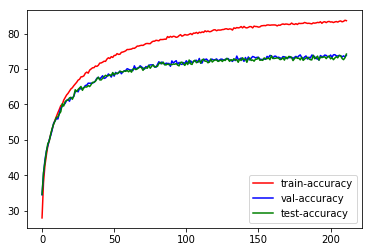

In [4]:
trainacc=[]
valacc=[]
testacc = []
traincost = []
valcost = []
epoch_count = 250
num = epoch_count
batch_size_len = 35

train = ""
print("Start", flush=True)
for epoch in range(num):  # loop over the dataset multiple times
    running_loss = 0.0
    running_loss_val = 0.0
    train_accuracy = 0.0
    val_accuracy = 0.0
    correct_train = 0
    total_train = 0
    correct_val = 0
    total_val = 0
    #print(epoch, flush=True)
    abcd_train = get_batch(X_Train, Y_Train,batch_size_len)
    for i, idx in enumerate(abcd_train, 0):
        # get the inputs
        x_batch = [X_Train.T[index] for index in idx]
        y_batch = [Y_Train.T[index] for index in idx]
        #print(len(x_batch))
        '''
        x_batch = x_batch + [X_Train.T[index][::-1] for index in idx]
        y_batch = y_batch + [Y_Train.T[index] for index in idx]
        #print(len(x_batch))
        '''
        x_batch = np.asarray(x_batch)
        y_batch = np.asarray(y_batch)
        y_batch_onehot = get_one_hot(y_batch,10)
        x_batch = x_batch.reshape(x_batch.shape[0],3,32,32)
        input_tensor = torch.from_numpy(x_batch)
        label_tensor = torch.from_numpy(y_batch_onehot)
        inputs = Variable(input_tensor.cuda()).float()
        labels = Variable(label_tensor.cuda()).long()
        true_labels = torch.max(labels,1)[1]
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, torch.max(labels, 1)[1])
        loss.backward()
        optimizer.step()

        running_loss += loss.data[0]
        if i % 100 == 99:    # print every 2000 mini-batches
            if(i+1 == 300):
                #print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100), flush=True)
                #train = train + str(epoch + 1) + ", " + str(i + 1) + ", loss=" + str(running_loss / 100) + "; "
                print("Epoch", epoch + 1, "Count:", i + 1, "loss:", running_loss/(batch_size_len*1.0), end=' ')
            traincost.append(running_loss / (batch_size_len*1.0))
            running_loss = 0.0
            
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == true_labels.data.long()).sum()
    train_accuracy = 100 * correct_train / (total_train + 0.0001)
        
    abcd = get_batch(X_Val, Y_Val,batch_size_len)
#     for l in abcd:
#         print(len(l), end=' ')
#     print("")
    for i, idx in enumerate(abcd, 0):
        # get the inputs
        x_batch_val = [X_Val.T[index] for index in idx]
        y_batch_val = [Y_Val.T[index] for index in idx]
        x_batch_val = np.asarray(x_batch_val)
        y_batch_val = np.asarray(y_batch_val)
        y_batch_onehot_val = get_one_hot(y_batch_val,10)
        x_batch_val = x_batch_val.reshape(x_batch_val.shape[0],3,32,32)
        input_tensor_val = torch.from_numpy(x_batch_val)
        label_tensor_val = torch.from_numpy(y_batch_onehot_val)
        inputs_val = Variable(input_tensor_val.cuda()).float()
        labels_val = Variable(label_tensor_val.cuda()).long()
        true_labels_val = torch.max(labels_val,1)[1]
        optimizer.zero_grad()
        outputs_val = net(inputs_val)
        loss_val = criterion(outputs_val, torch.max(labels_val, 1)[1])
        running_loss_val += loss_val.data[0]
#         if(i > 97):
#             print("Hello", i)
        if i == len(abcd) - 1:    # print every 2000 mini-batches
            test_accuracy = test_acc()
            print("\t", i, "loss_val:", running_loss_val/(batch_size_len*1.0))#, "Test:", test_accuracy)
            valcost.append(running_loss_val/(batch_size_len*1.0))
            running_loss_val = 0.0
        
        _, predicted_val = torch.max(outputs_val.data, 1)
        total_val += labels_val.size(0)
        correct_val += (predicted_val == true_labels_val.data.long()).sum()
    val_accuracy = 100 * correct_val / total_val
    trainacc.append(train_accuracy)
    valacc.append(val_accuracy)
    testacc.append(test_accuracy)
    if(test_accuracy>=74.0):
        break
    
print('Finished Training', flush=True)
print('Training Accuracy ',trainacc, flush=True)
print('validation Accuracy',valacc, flush=True)
print("Test:", test_acc(), flush=True)

plt.figure()
plt.plot(trainacc, 'r', label ='train-accuracy')
plt.plot(valacc, 'b', label = 'val-accuracy')
plt.plot(testacc, 'g', label = 'test-accuracy')
plt.legend()
plt.savefig("test.png")


x_t = []
x_v = []

for i in range(len(traincost)):
    x_t.append((i+1)*batch_size_len)

for i in range(len(valcost)):
    x_v.append((i+1)*batch_size_len)
'''
plt.figure()
plt.plot(x_t,traincost, 'b', label = 'traincost')
plt.plot(x_v,valcost, 'r', label = 'valcost')
plt.legend()
plt.savefig("test1.png")
'''

In [5]:
print(valacc)
print(testacc)

[34.49624060150376, 40.340852130325814, 44.310776942355886, 46.81704260651629, 48.340852130325814, 49.99498746867168, 51.21804511278196, 52.771929824561404, 54.636591478696744, 55.32832080200501, 56.02005012531328, 55.8796992481203, 57.51378446115288, 58.97744360902256, 59.3984962406015, 59.86967418546366, 60.26065162907268, 61.07268170426065, 61.41353383458647, 60.87218045112782, 61.91478696741854, 61.81453634085213, 62.265664160401, 63.54887218045113, 63.83959899749373, 63.528822055137844, 64.49122807017544, 64.35087719298245, 64.50125313283208, 64.70175438596492, 65.32330827067669, 65.42355889724311, 65.99498746867168, 65.95488721804512, 65.96491228070175, 65.99498746867168, 66.19548872180451, 66.63659147869674, 67.36842105263158, 67.62907268170426, 67.12781954887218, 67.59899749373433, 68.08020050125313, 67.31829573934837, 67.468671679198, 67.91979949874687, 68.58145363408521, 68.25062656641605, 67.69924812030075, 68.82205513784461, 67.96992481203007, 69.03258145363408, 68.58145363